<a href="https://colab.research.google.com/github/theclassofai/COVID_19/blob/master/Covid_Analysis_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
os.environ['KAGGLE_USERNAME'] = "theclassofai" # username from the json file
os.environ['KAGGLE_KEY'] = "xxx" # key from the json file
!kaggle competitions download -c covid19-global-forecasting-week-2

  0% 0.00/731k [00:00<?, ?B/s]
100% 731k/731k [00:00<00:00, 101MB/s]
  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 104MB/s]
  0% 0.00/357k [00:00<?, ?B/s]
100% 357k/357k [00:00<00:00, 99.9MB/s]


In [0]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [7]:
train=pd.read_csv(r"/content/train.csv")
test=pd.read_csv(r"/content/test.csv")
train

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
19693,29363,NaN,Zimbabwe,2020-03-24,3.0,1.0
19694,29364,NaN,Zimbabwe,2020-03-25,3.0,1.0
19695,29365,NaN,Zimbabwe,2020-03-26,3.0,1.0
19696,29366,NaN,Zimbabwe,2020-03-27,5.0,1.0


In [4]:
train.sample(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
51,52,NaN,Afghanistan,2020-03-13,7.0,0.0
4466,6645,Jiangxi,China,2020-03-06,935.0,1.0
17273,25755,New York,US,2020-03-16,967.0,10.0
12442,18548,NaN,Panama,2020-03-09,0.0,0.0
3166,4718,NaN,Chad,2020-02-08,0.0,0.0
16068,23956,Indiana,US,2020-03-17,30.0,2.0
12865,19202,NaN,Qatar,2020-01-23,0.0,0.0
4105,6119,Hong Kong,China,2020-02-09,29.0,1.0
16642,24827,Minnesota,US,2020-02-17,0.0,0.0
10717,15965,NaN,Maldives,2020-03-26,13.0,0.0


In [5]:
test.sample(10)

,ForecastId,Province_State,Country_Region,Date
12359,12360,NaN,United Kingdom,2020-04-06
10243,10244,Illinois,US,2020-03-28
1407,1408,NaN,Burkina Faso,2020-04-19
2350,2351,Guangdong,China,2020-04-16
10517,10518,Maine,US,2020-04-13
590,591,Tasmania,Australia,2020-04-19
444,445,Northern Territory,Australia,2020-04-02
211,212,NaN,Angola,2020-04-27
718,719,NaN,Austria,2020-04-18
4397,4398,NaN,Eritrea,2020-03-30


### Now let's start EDA

In [6]:
df = train.fillna('NA').groupby(['Country_Region','Province_State','Date'])['ConfirmedCases'].sum() \
                          .groupby(['Country_Region','Province_State']).max().sort_values() \
                          .groupby(['Country_Region']).sum().sort_values(ascending = False)

top10 = pd.DataFrame(df).head(10)
top10

,ConfirmedCases
Country_Region,
US,121326.0
Italy,92472.0
China,82000.0
Spain,73235.0
Germany,57695.0
France,38105.0
Iran,35408.0
United Kingdom,17304.0
Switzerland,14076.0


In [21]:
# Confirmed COVID-19 Cases by country
fig = px.bar(top10, x=top10.index, y='ConfirmedCases', 
             labels={'x':'Country'}, color="ConfirmedCases", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Confirmed COVID-19 cases by country')
fig.show()

In [20]:
## Confirmed COVID-19 cases per day in US

df_by_date = pd.DataFrame(train.fillna('NA').groupby(
    ['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'Italy') 
&(df_by_date.Date >= '2020-03-11')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)

fig.update_layout(title_text='Confirmed COVID-19 cases per day in Italy')
fig.show()

### Now let's do the time evaluation 

In [0]:
def pltCountry_cases(ConfirmedCases,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['ConfirmedCases'],linewidth=6)
        plt.xticks(rotation=90)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )


def pltCountry_fatalities(Fatalities,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['Fatalities'],linewidth=6)
        plt.xticks(rotation=90)
        plt.legend(labels)
        ax.set(title='Evolution of the number of fatalities' )

In [31]:
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
df

,Date,Country_Region,Id,ConfirmedCases,Fatalities
0,2020-01-22,Afghanistan,1,0.0,0.0
1,2020-01-22,Albania,101,0.0,0.0
2,2020-01-22,Algeria,201,0.0,0.0
3,2020-01-22,Andorra,301,0.0,0.0
4,2020-01-22,Angola,401,0.0,0.0
...,...,...,...,...,...
11586,2020-03-28,Uzbekistan,28967,104.0,2.0
11587,2020-03-28,Venezuela,29067,119.0,2.0
11588,2020-03-28,Vietnam,29167,174.0,0.0
11589,2020-03-28,Zambia,29267,28.0,0.0


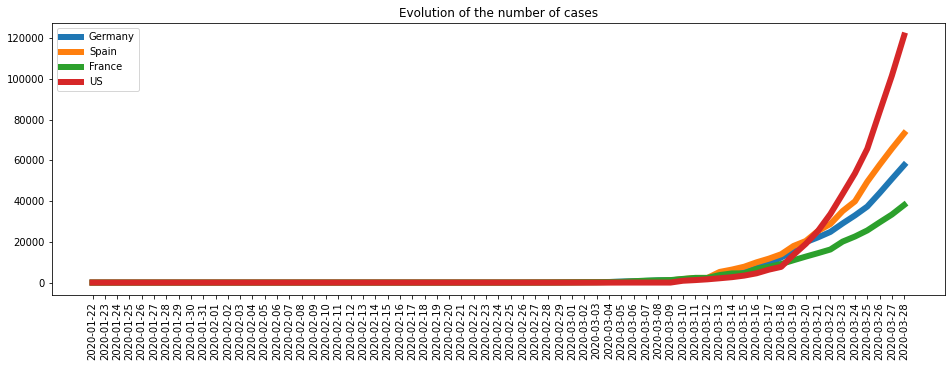

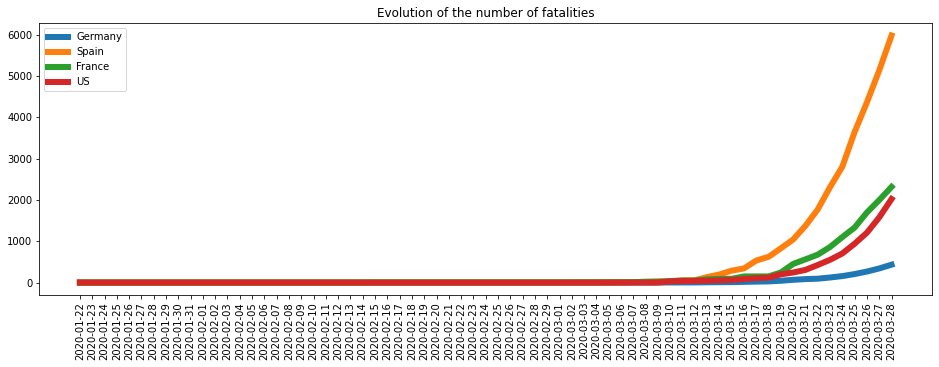

In [30]:
pltCountry_cases('ConfirmedCases', 'Germany','Spain','France','US')
pltCountry_fatalities('Fatilities','Germany','Spain','France','US')